# **TheLook eCommerce Data Analysis**


TheLook is a fictitious eCommerce clothing site developed by the Looker team. The dataset contains information about customers, orders, logistics, web events, and digital marketing campaigns. The contents of this dataset are synthetic and are provided by industries practitioners for the purpose of product discovery, testing, and evaluation.

**Objective**

This project is carried out to evaluate the performance of TheLook eCommerce's Growth (Orders & Revenue) and Customer Retention


# **EDA (Exploratory Data Analysis**

*FYI the results of the query are taken with screenshots which cannot cover the full result of the query. To see and run the query on Google BigQuery, please proceed to this [link](https://console.cloud.google.com/bigquery?sq=277520631063:e36a4a8b227042a18873f253e5c87755)


**1. Total users who completed the order and total orders per month. Using time frame from January 2019 until April 2022.**

In [ ]:
SELECT 
  FORMAT_TIMESTAMP("%B-%Y",TIMESTAMP_TRUNC(timestamp(created_at),MONTH,"UTC")) month,
  COUNT(DISTINCT user_id) AS total_user,
  COUNT(order_id) AS total_order
FROM `bigquery-public-data.thelook_ecommerce.orders`
WHERE status = "Complete" AND
  created_at BETWEEN "2019-01-01" AND "2022-04-30"
GROUP BY 1
ORDER BY PARSE_TIMESTAMP("%B-%Y",month);

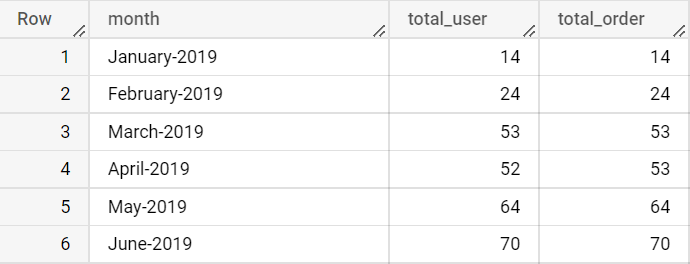

**2. Average order value and total number of unique users, grouped by month. Using time frame from January 2019 until April 2022.**

In [ ]:
SELECT 
  DATE(TIMESTAMP_TRUNC(timestamp(created_at),MONTH,"UTC")) month_year,
  COUNT(DISTINCT user_id) AS total_distinct_user,
  ROUND(SUM(sale_price)/COUNT(*),1) AS average_order_value
FROM `bigquery-public-data.thelook_ecommerce.order_items`
WHERE created_at BETWEEN "2019-01-01" AND "2022-04-30"
GROUP BY 1
ORDER BY DATE(month_year);

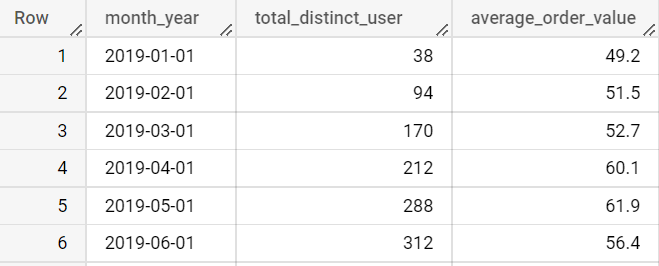

**3. First and the last name of users from the youngest and the oldest age of each gender.**

In [ ]:
WITH youngest_oldest_age AS (
  SELECT 
    MIN(age) youngest,
    MAX(age) oldest
  FROM  `bigquery-public-data.thelook_ecommerce.users`
  )
SELECT 
  gender, 
  age, 
  first_name, 
  last_name
FROM `bigquery-public-data.thelook_ecommerce.users` A
WHERE A.age = (SELECT youngest FROM youngest_oldest_age)
UNION ALL
SELECT 
  gender, 
  age, 
  first_name, 
  last_name
FROM `bigquery-public-data.thelook_ecommerce.users` A
WHERE A.age = (SELECT oldest FROM youngest_oldest_age)
ORDER BY age;

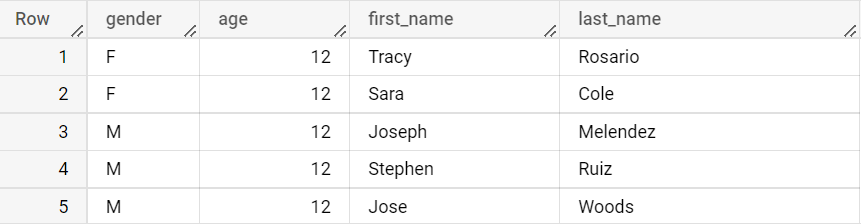

**4. Most profitable product and its profile detail breakdown by month.**

In [ ]:
WITH main AS (
 SELECT 
  order_items.product_id AS product_id,
  products.name AS product_name,
  ROUND(SUM(order_items.sale_price),1) total_sales,
  ROUND(SUM(products.cost),1) total_cost,
  ROUND(SUM(order_items.sale_price)-SUM(products.cost),1) AS profit
 FROM `bigquery-public-data.thelook_ecommerce.order_items` order_items
  INNER JOIN `bigquery-public-data.thelook_ecommerce.products` products
  ON order_items.product_id = products.id
 GROUP BY 1, 2
 ORDER BY profit DESC
 LIMIT 5),

main_2 AS(
 SELECT DATE(TIMESTAMP_TRUNC(timestamp(order_items.created_at),MONTH,"UTC")) month, 
  main.product_id,
  main.product_name,
  main.total_sales,
  main.total_cost,
  main.profit,
 FROM main
  LEFT JOIN `bigquery-public-data.thelook_ecommerce.order_items` order_items
  ON main.product_id = order_items.product_id
 GROUP BY 1, 2, 3, 4, 5, 6
 ORDER BY DATE(month)
)

SELECT *, RANK() OVER(PARTITION BY main_2.month ORDER BY profit) AS rank
FROM main_2
ORDER BY DATE(month),2;

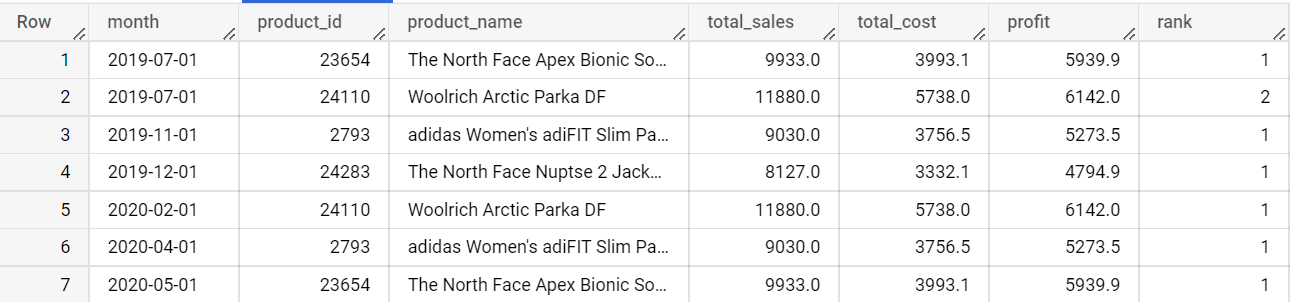

**5. Month to date of total revenue in each product categories of past 3 months (current date April 15, 2022), breakdown by date.**

In [ ]:
WITH april AS(
  SELECT
    DATE(TIMESTAMP_TRUNC(timestamp(order_items.created_at),DAY,"UTC")) AS date,
    products.category,
    ROUND(SUM(order_items.sale_price),1) revenue
  FROM `bigquery-public-data.thelook_ecommerce.order_items` order_items
    LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` products
    ON order_items.product_id = products.id
  WHERE order_items.status = "Complete" AND DATE(order_items.created_at) > DATE_SUB(date '2022-04-15', interval 15 DAY) AND DATE(order_items.created_at) < '2022-04-16'
  GROUP BY date, products.category
  ORDER BY date),
  
march AS(
  SELECT
    DATE(TIMESTAMP_TRUNC(timestamp(order_items.created_at),DAY,"UTC")) AS date,
    products.category,
    ROUND(SUM(order_items.sale_price),1) revenue
  FROM `bigquery-public-data.thelook_ecommerce.order_items` order_items
    LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` products
    ON order_items.product_id = products.id
  WHERE order_items.status = "Complete" AND DATE(order_items.created_at) > DATE_SUB(date '2022-03-15', interval 15 DAY) AND DATE(order_items.created_at) < '2022-03-16'
  GROUP BY date, products.category
  ORDER BY date),

february AS(
  SELECT
    DATE(TIMESTAMP_TRUNC(timestamp(order_items.created_at),DAY,"UTC")) AS date,
    products.category,
    ROUND(SUM(order_items.sale_price),1) revenue
  FROM `bigquery-public-data.thelook_ecommerce.order_items` order_items
    LEFT JOIN `bigquery-public-data.thelook_ecommerce.products` products
    ON order_items.product_id = products.id
  WHERE order_items.status = "Complete" AND DATE(order_items.created_at) > DATE_SUB(date '2022-03-15', interval 15 DAY) AND DATE(order_items.created_at) < '2022-03-16'
  GROUP BY date, products.category
  ORDER BY date)

SELECT *
FROM april
UNION ALL
SELECT *
FROM march
UNION ALL
SELECT *
FROM february
ORDER BY date DESC;

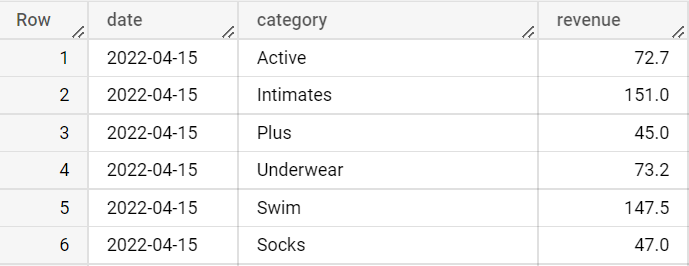

#**Growth (Orders & Revenue) and Customer Retention Analysis**


**6. Monthly growth of TPO (# of completed orders) and TPV (# of revenue) in percentage breakdown by product categories, ordered by time descendingly. Using time frame from Jan 2019 until April 2022.**

In [ ]:
WITH order_1 AS (
  SELECT
    DATE_TRUNC(DATE(orderitems.created_at), month) AS month,
    products.category AS categories,
    COUNT(orderitems.order_id) AS orders,
    ROUND(SUM(orderitems.sale_price),2) AS revenue
  FROM
    `bigquery-public-data.thelook_ecommerce.order_items`orderitems
  INNER JOIN
    `bigquery-public-data.thelook_ecommerce.products`products
  ON
    orderitems.product_id=products.id
  WHERE
    DATE(orderitems.created_at) BETWEEN '2019-01-01'
    AND '2022-04-30'
    AND orderitems.status = 'Complete'
  GROUP BY 1,2
  ORDER BY 2,1 ),

 order_2 AS (
  SELECT
    *,
    LAG(orders) OVER(PARTITION BY categories ORDER BY month) AS prev_order,
    LAG(revenue)OVER(PARTITION BY categories ORDER BY month) AS prev_revenue
  FROM
    order_1
  ORDER BY
    2,
    1 )
SELECT
  month,
  categories,
  ROUND((((orders-prev_order)/ prev_order)*100),2) AS order_growth_precentage,
  ROUND((((revenue-prev_revenue)/prev_revenue)*100),2) AS revenue_growth_percentage
FROM
  order_2
ORDER BY
  2,
  1 ASC;

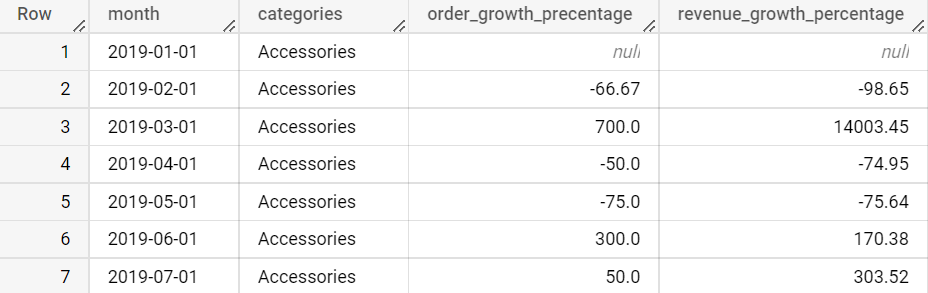

Visualization of avg. monthly orders & revenue growth by cartegory using Google Data Studio

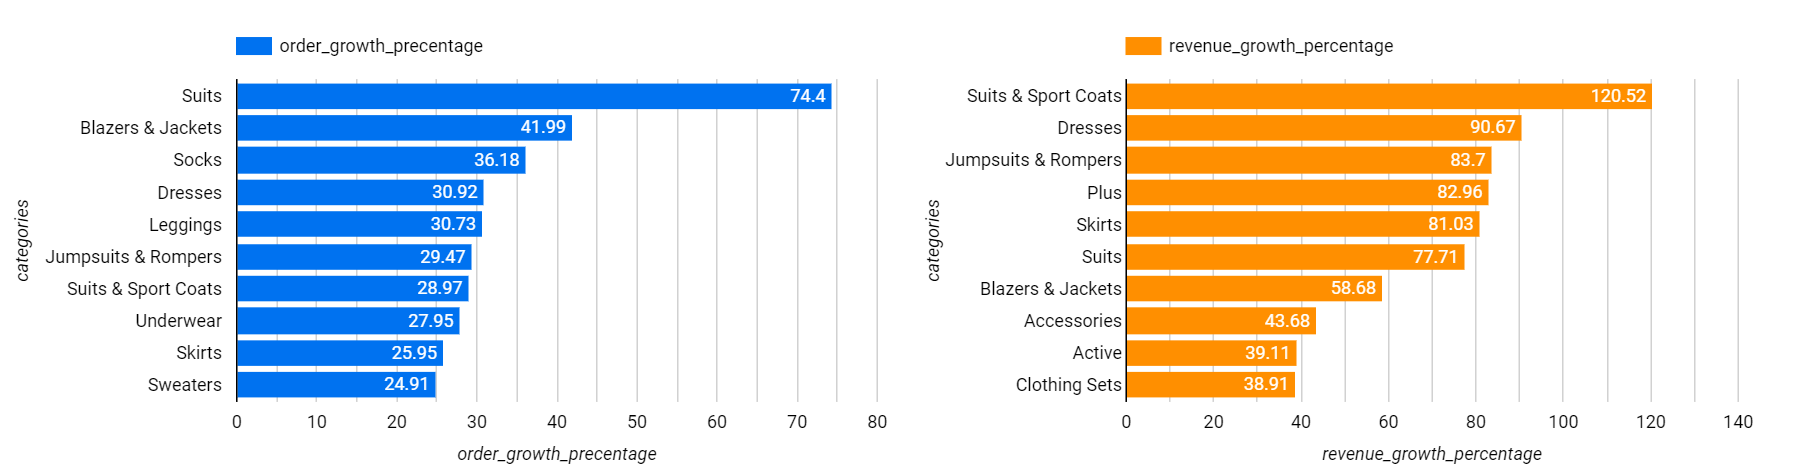

Insights:


*   Suits  product category has the highest avg. monthly order growth from Jan 2019 - April 2022 
*   Suits & Sport Coats product category has the highest avg. monthly revenue growth from Jan 2019 - April 2022 




**7. Monthly retention cohorts (the groups, or cohorts are defined based upon the date that a user purchased a product) and how many of them (%) coming back from the following months in 2019-2022.
Notes: initial start date is defined using first purchase from each user in table order.**

In [ ]:
WITH cohort_1 AS (
  SELECT
    user_id,
    MIN(DATE(DATE_TRUNC(created_at, month))) AS cohort_month
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`
      WHERE
    status IN ('Shipped', 'Completed', 'Returned')
  GROUP BY  1 ),

  user_activities AS (
  SELECT
    orders.user_id AS user_id,
    DATE_DIFF((DATE(DATE_TRUNC(created_at, month))), cohort_1.cohort_month, month) AS month_number
  FROM
    `bigquery-public-data.thelook_ecommerce.orders`orders
  LEFT JOIN cohort_1
  ON  orders.user_id=cohort_1.user_id
    WHERE EXTRACT(year FROM cohort_1.cohort_month) IN (2019, 2020, 2021, 2022)
  GROUP BY 1, 2
  ),

cohort_size AS (
  SELECT
    cohort_month,
    count (1) AS num_users
  FROM cohort_1
  GROUP BY 1
  ORDER BY 1 ),
  
retention_table AS (
  SELECT
    C1.cohort_month AS cohort_month,
    UA.month_number AS month_number,
    COUNT(1) AS num_users
  FROM user_activities UA
  LEFT JOIN cohort_1 C1
  ON UA.user_id=C1.user_id
  GROUP BY 1, 2
  ORDER BY 1, 2 )

SELECT
  RT.cohort_month AS cohort_month,
  CS.num_users AS cohort_size,
  RT.month_number AS month_number,
  RT.num_users AS total_user,
  CAST(RT.num_users AS decimal)/CS.num_users AS percentage
FROM
  retention_table RT
LEFT JOIN
  cohort_size CS
ON
  RT.cohort_month = CS.cohort_month
WHERE
  RT.cohort_month IS NOT NULL
ORDER BY
  1,
  3

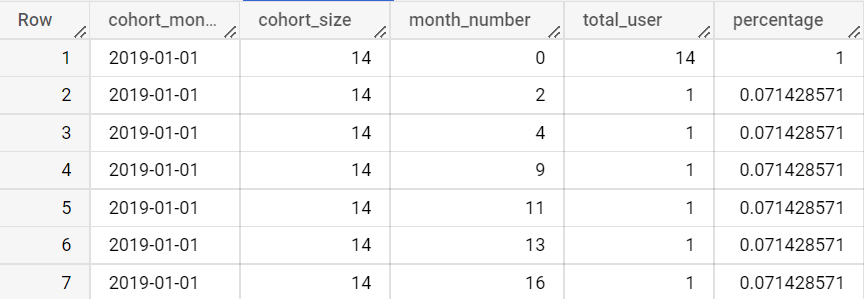

Visualizations of the table above

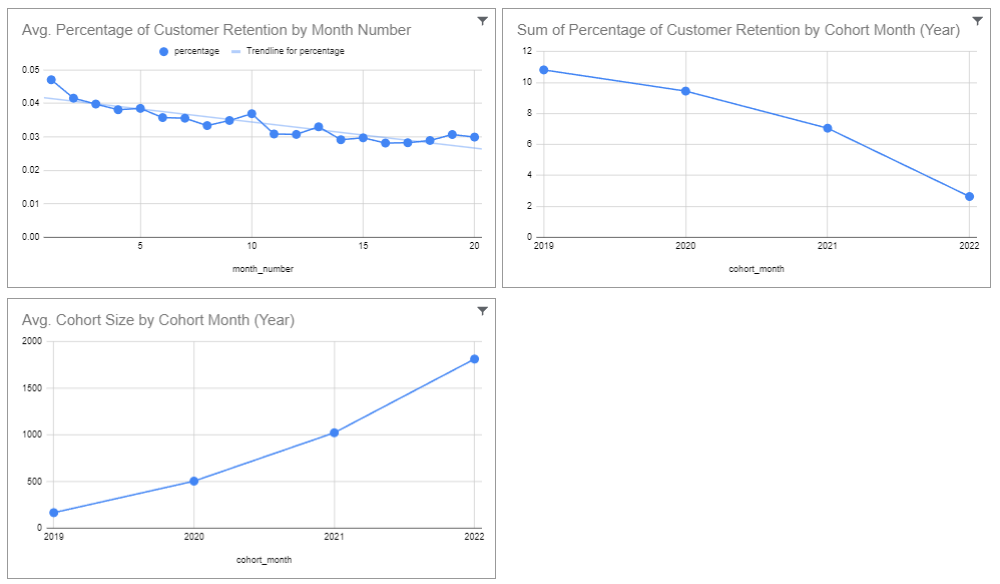

Insights: 


*   On average, our percentage of customer retentions are decreasing to 5% on the first month and end up at 3% on the 20th month. We may need to improve our services or promos to retain our customer more than 5% on the first month when they've purchased
*   Each year from 2019-2022, our percentage of customer retention is decreasing. We may need to evaluate more on what we've done each year's to analyze the root cause of this down trend of customer retention
*   The avg. cohort size per month is tend to increase each year. This maybe due to the better promotion or discount that we offer year by year.

